# Lyttelton Times Topic Modeling

### A prototype of topic modeling using MALLET

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

## 0 Environment

Ubuntu 18.04.1

Python 3.6.6

Jupyter 4.4.0

Mallet 2.0

Gensim 3.4.0

Directory structure:
```
data601/
├── data
│   ├── Lyttelton_Times.csv
│   └── Lyttelton_Times.txt
└── scripts
    └── LytteltonTimes
        ├── LytteltonTimes.ipynb
        ├── model
        │   ├── model_bi.mallet
        │   └── model.mallet
        └── output
            ├── composition_bi.txt
            ├── composition.txt
            ├── keys_bi.txt
            ├── keys_py.txt
            ├── keys.txt
            ├── state_bi.gz
            └── state.gz

```


## 1 Install MALLET LDA Toolkit

Install the toolkit in Linux OS.

```
#!/bin/bash

git clone https://github.com/mimno/Mallet.git

cd Mallet

ant
```

Need add `mallet` path to PATH of .bashrc file.

```
export PATH="/usr/local/share/Mallet/bin:$PATH"

```

## 2 Lyttelton Times dataset preprocessing

There are two primary methods for importing data into MALLET format, first when the source data consists of many separate files, and second when the data is contained in a single file, with one instance per line.

We use the second method, One file, one instance per line.

Assume the data is in the following format:

```
[id] [title] [text of the page...]
```

In this case, the first token of each line (whitespace delimited, with optional comma) becomes the instance name, the second token becomes the label, and all additional text on the line is interpreted as a sequence of word tokens. Note that the data in this case will be a vector of feature/value pairs, such that a feature consists of a distinct word type and the value is the number of times that word occurs in the text.

### 2.1 Load given TSV file to CSV file

The given Lyttelton Times dataset is a TSV file, we transform it to CSV file to feed MALLET.

In [43]:
file_path = '../../data/Lyttelton_Times.txt'

import pandas as pd
pd.set_option('display.expand_frame_repr', False)

df = pd.read_table(file_path, header=None)

df.columns = ['id', 'url', 'publisher', 'time', 'title', 'content']

print('Shape of dataframe:', df.shape)

df.sample(3)

Shape of dataframe: (28904, 6)


,id,url,publisher,time,title,content
7470,2022711,http://api.digitalnz.org/records/2022711/source,Lyttelton Times,1855-12-05T00:00:00.000Z,Page 11 Advertisements Column 3 (Lyttelton Tim...,"Ex ""' Caroline Agness,"" 1 00 CASKS Marzetti's ..."
17218,2176182,http://api.digitalnz.org/records/2176182/source,Lyttelton Times,1858-12-29T00:00:00.000Z,"INDIA AND THE EAST. (Lyttelton Times, 29 Decem...",INDIA AND THE EAST.(From our Galle corresponde...
14996,2137929,http://api.digitalnz.org/records/2137929/source,Lyttelton Times,1858-08-28T00:00:00.000Z,"FRANCE. (Lyttelton Times, 28 August 1858)","FRANCE.The 'Argus' Correspondent, refers to th..."


### 2.2 Select columns

We need only id, title, and contant columns as input.

In [2]:
df = df[['id', 'title', 'content']]
df.sample(3)

,id,title,content
28694,2387856,Page 1 Advertisements Column 2 (Lyttelton Time...,"THE CANTERBURY PHOTOGRAPHIC ROOMS, CORNER OF H..."
2877,1956287,"CORRESPONDENCE. (Lyttelton Times, 25 June 1853)",CORRESPONDENCE.To the Editor of the Lyttelton ...
10165,2058569,Page 9 Advertisements Column 2 (Lyttelton Time...,CANTERBURY ASSOCIATION'S RESVES. Provincial Se...


### 2.3 Correct error words

We could correct error words from OCR to improve the quality of dataset. Now we leave it as ***future work***.

### 2.4 General NLP processing

Generally there are several NLP processing including tokenization, stopwords and stemming.

1. Tokenization - Segregation of the text into its individual constitutent words.
1. Stopwords - Throw away any words that occur too frequently as its frequency of occurrence will not be useful in helping detecting relevant texts. (as an aside also consider throwing away words that occur very infrequently).
1. Stemming - combine variants of words into a single parent word that still conveys the same meaning

We can confirm under command line environment MALLET can handle tokenization and stopwords, but cannot handle stemming, we could add stemming processing before using MALLET. However, if we are training a topic model on English text, stemming is almost certainly not useful. The topic modeling can usually group related words together simply by context, and stemming often produces odd-looking not-quite-words that are difficult for users to interpret.

However, in Python environment we use wrapper in packages, which provide interface with MALLET but the input to MALLET are corpus not files or directory, so in this circumstances we need perform general NLP processing before using MALLET wrapper in packages. The general NLP processing will be shown in the 3.2 part.

Finally, we save the preprocessed dataframe as CSV file.

In [3]:
file_path = '../../data/Lyttelton_Times.csv'

df.to_csv(file_path, encoding='utf-8', index=False, header=False)

In [4]:
#df_test = pd.read_csv(file_path, header=None)
#df_test.sample(3)

## 3 Topic Modeling using MALLET

There are two methods using MALLET, one is command line, the other one is Gensim wrapper.

### 3.1 MALLET in command line

In this way we need use linux bash command line. Below is the sequence of topic modeling from import data to output topic text.

In [5]:
%%bash

FILE_PATH="../../data/Lyttelton_Times.csv"

mallet import-file --input $FILE_PATH \
                   --output ./model/model.mallet \
                   --keep-sequence \
                   --remove-stopwords

mallet train-topics --input ./model/model.mallet \
                    --num-topics 35 \
                    --optimize-interval 10 \
                    --output-state ./output/state.gz \
                    --output-topic-keys ./output/keys.txt \
                    --output-doc-topics ./output/composition.txt

cat ./output/keys.txt

0	0.05237	tons lyttelton freight wellington schooner passengers passage ship wool port master apply london agents sail vessel otago cargo miles sydney 
1	0.0265	lyttelton books office times paper advertisements insertion black blue laid subscribers sale received copies orders publication stationery christchurch kaiapoi day 
2	0.07621	land acres street christchurch house road town sale section apply property sections ollivier freehold cashel particulars acre situated years frontage 
3	0.03367	sale tea books iron lyttelton cases patent assortment large boxes nails knives machines street paper goods forks glasses dishes table 
4	0.04705	sale auction public sell o'clock lyttelton christchurch alport saturday received market horses terms place instructions furniture thursday messrs harness stock 
5	0.05924	lyttelton meeting society committee o'clock christchurch evening held hall members secretary esq canterbury town monday times notice hon messrs requested 
6	0.04159	boots white ladies bla

Mallet LDA: 35 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 5355
total tokens: 9269751
<10> LL/token: -9.96543
<20> LL/token: -9.41168
<30> LL/token: -9.27573
<40> LL/token: -9.21567

0	0.14286	tons lyttelton wellington freight schooner passengers ship passage port wool otago london master sydney agents vessel apply sail nelson cargo 
1	0.14286	books lyttelton office paper times advertisements black insertion blue laid sale received stationery subscribers orders copies printing music letter publication 
2	0.14286	land apply acres sale christchurch street house particulars town lyttelton section situated road sections sold acre property freehold years terms 
3	0.14286	sale tea white lyttelton patent case boxes oil cases street large iron assortment assorted brushes table fancy christchurch glass nails 
4	0.14286	sale auction public sell o'clock christchurch lyttelton received alport instructions terms furniture saturday thursday place horses market messrs rooms stock

For bi-grams:

In [6]:
%%bash

FILE_PATH="../../data/Lyttelton_Times.csv"

mallet import-file --input $FILE_PATH \
                   --output ./model/model_bi.mallet \
                   --keep-sequence-bigrams \
                   --remove-stopwords

mallet train-topics --input ./model/model_bi.mallet \
                    --num-topics 35 \
                    --optimize-interval 10 \
                    --output-state ./output/state_bi.gz \
                    --output-topic-keys ./output/keys_bi.txt \
                    --output-doc-topics ./output/composition_bi.txt

cat ./output/keys_bi.txt

0	0.02015	men general troops war natives enemy force officers guns wounded native left town killed day army place colonel taranaki attack 
1	0.03744	provincial office secretary government christchurch notice province payment amount public tenders land superintendent persons honor money assistance lyttelton person colony 
2	0.0489	mr water ship time captain day made vessel morning feet boat great left weather found fire board sea night days 
3	0.03391	cases casks hhds ditto lyttelton qr sale assorted boxes ale iron stores brandy tobacco undersigned case candles sherry chests bales 
4	0.00617	pills complaints holloway ointment world liver remedy lyttelton health professor debility medicine sore bowels diseases mr skin derangement cure medicines 
5	0.06875	lyttelton christchurch street public begs inform mr business goods notice hotel inhabitants canterbury attention patronage orders made store horses merit 
6	0.04229	christchurch street sale london undersigned orders lyttelton house publ

Mallet LDA: 35 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 5477
total tokens: 9563110
<10> LL/token: -9.75
<20> LL/token: -9.1747
<30> LL/token: -9.04263
<40> LL/token: -8.98667

0	0.14286	general men war troops force received news place officers enemy military army city arrived british made attack great india colonel 
1	0.14286	provincial office government secretary christchurch payment amount province tenders notice persons superintendent honor public assistance money person colony bills england 
2	0.14286	fire time day night men morning left side made half round head man water found miles clock small back guns 
3	0.14286	cases casks ditto hhds case boxes qr lyttelton sale undersigned ale iron bales stores bags assorted peacock brandy wool christchurch 
4	0.14286	pills holloway complaints ointment world liver lyttelton remedy health professor medicine debility sore bowels mr diseases skin cure medicines times 
5	0.14286	lyttelton christchurch street inform mr pub

### 3.2 MALLET in Python

Using command line MALLET for topic modeling is simple but lack of NLP detail and control. The rich NLP packages in Python let us perform the same (or better?) process of topic modeling and we could know and control more detail in the process. The drawback is that MALLET in Python only do LDA topic modeling part, we need use Python packages to execute NLP processes (discussed in 2.4 section), which are addictional work compare to MALLET in command line.

There is a Python wrapper - models.ldamallet - for Latent Dirichlet Allocation (LDA) from MALLET in Gensim package.

This module allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents, using an (optimized version of) collapsed gibbs sampling from MALLET.

Example:

```
>>> model = gensim.models.LdaMallet('/usr/local/mallet-2.0.7/bin/mallet', 
                                    corpus=my_corpus, 
                                    num_topics=20, 
                                    id2word=dictionary)
>>> print model[my_vector]  # print LDA topics of a document

```

We should start from general NLP processing for dataframe, and create dictionary and corpus for topic modeling, then we build topic model, and training it to get topics.

First of all, import all packages we need.

In [8]:
#import re
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# NLTK for stop words
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# spacy for lemmatization
#! python3 -m spacy download en
import spacy

# Plotting tools
#import pyLDAvis
#import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

#### 3.2.1 Generate data

We only use "content" column in the dataframe, and convert each row to list.

In [10]:
data = df.content.values.tolist()
print(data[:1])

['fTIHE price of Advertisements in this Paper ■A- is, threepence a line for the first insertion, and a penny a line for every subsequent one. All communications to the Editor are requested to be addressed to the Office of the Lyttelton Times, Section 2, Norwich Quay, Lyttelton, where the Paper may be obtained. Advertisements must be left at this Office before Thursday evening, for insertion of the same week, and must be paid for at the time of insertion. NOTICE. ~ HIS EXCELLENCY SIR GEORGE GREY having declared that he will raise no objection to the erection of Canterbury into a separate Province, if the power be left in his hands, and if the settlers in Canterbury desire it, we, the undersigned, Magistrates of the district, think it right that opportunities should be given of ascertaining the wishes of the people on this important subject. For this purpose Public Meetings will be held at the Mitre Hotel, Lyttelton, on Wednesday, Aug. 13, at Two o\'clock, p.m.; and at the Golden Fleece 

#### 3.2.2 Prepare stopwords

We use NLTK stop words, and customize the stop words.

In [11]:
stop_words = stopwords.words('english')

# customize
stop_words.extend(['christchurch', 'lyttelton', 'times',
                   'from'])

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

#### 3.2.3 Tokenize words and Clean-up text

We tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.
Gensim’s `simple_preprocess()` is great for this. Additionally we set `deacc=True` to remove the punctuations.

In [12]:
def sentences_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sentences_to_words(data))

print(data_words[:1])

[['ftihe', 'price', 'of', 'advertisements', 'in', 'this', 'paper', 'is', 'threepence', 'line', 'for', 'the', 'first', 'insertion', 'and', 'penny', 'line', 'for', 'every', 'subsequent', 'one', 'all', 'communications', 'to', 'the', 'editor', 'are', 'requested', 'to', 'be', 'addressed', 'to', 'the', 'office', 'of', 'the', 'lyttelton', 'times', 'section', 'norwich', 'quay', 'lyttelton', 'where', 'the', 'paper', 'may', 'be', 'obtained', 'advertisements', 'must', 'be', 'left', 'at', 'this', 'office', 'before', 'thursday', 'evening', 'for', 'insertion', 'of', 'the', 'same', 'week', 'and', 'must', 'be', 'paid', 'for', 'at', 'the', 'time', 'of', 'insertion', 'notice', 'his', 'excellency', 'sir', 'george', 'grey', 'having', 'declared', 'that', 'he', 'will', 'raise', 'no', 'objection', 'to', 'the', 'erection', 'of', 'canterbury', 'into', 'separate', 'province', 'if', 'the', 'power', 'be', 'left', 'in', 'his', 'hands', 'and', 'if', 'the', 'settlers', 'in', 'canterbury', 'desire', 'it', 'we', 'the'

#### 3.2.4 Creating Bigram Model

Gensim’s `Phrases` model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to `Phrases` are `min_count` and `threshold`. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

# Get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

print(bigram_mod[data_words[0]])

['ftihe', 'price', 'of', 'advertisements', 'in', 'this', 'paper', 'is', 'threepence_line', 'for', 'the', 'first', 'insertion', 'and', 'penny_line', 'for', 'every', 'subsequent', 'one', 'all', 'communications', 'to', 'the', 'editor', 'are', 'requested', 'to', 'be', 'addressed', 'to', 'the', 'office', 'of', 'the', 'lyttelton', 'times', 'section', 'norwich_quay', 'lyttelton', 'where', 'the', 'paper', 'may', 'be', 'obtained', 'advertisements', 'must', 'be', 'left', 'at', 'this', 'office', 'before', 'thursday', 'evening', 'for', 'insertion', 'of', 'the', 'same', 'week', 'and', 'must', 'be', 'paid', 'for', 'at', 'the', 'time', 'of', 'insertion', 'notice', 'his', 'excellency', 'sir', 'george_grey', 'having', 'declared', 'that', 'he', 'will', 'raise', 'no', 'objection', 'to', 'the', 'erection', 'of', 'canterbury', 'into', 'separate', 'province', 'if', 'the', 'power', 'be', 'left', 'in', 'his', 'hands', 'and', 'if', 'the', 'settlers', 'in', 'canterbury', 'desire', 'it', 'we', 'the', 'undersigne

#### 3.2.5 Remove Stopwords, Make Bigrams and Lemmatize

The bigrams model is ready. Then we define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [14]:
# Define functions for stopwords, bigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sentence in texts:
        doc = nlp(" ".join(sentence)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Call the functions in order.

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['ftihe', 'price', 'advertisement', 'paper', 'threepence_line', 'first', 'insertion', 'penny_line', 'subsequent', 'communication', 'editor', 'request', 'addressed', 'office', 'section', 'norwich_quay', 'paper', 'may', 'obtain', 'advertisement', 'must', 'left', 'office', 'thursday', 'evening', 'insertion', 'week', 'must', 'pay', 'time', 'insertion', 'notice', 'excellency', 'sir', 'declare', 'raise', 'objection', 'erection', 'canterbury', 'separate', 'province', 'power', 'leave', 'hand', 'settler', 'canterbury', 'desire', 'undersigned', 'magistrate', 'district', 'think', 'right', 'opportunity', 'give', 'ascertain', 'wish', 'people', 'important', 'subject', 'purpose', 'public', 'meeting', 'hold', 'mitre_hotel', 'wednesday', 'aug', 'clock', 'golden_fleece', 'hotel', 'thursday', 'aug', 'clock', 'noon', 'godley', 'beittan', 'gouland', 'phillip', 'tancrbd', 'russell', 'dean', 'rhode', 'wakisfield', 'public', 'dinner', 'hold', 'mitre_hotel', 'inst', 'commemorate', 'hold', 'first', 'public', '

#### 3.2.6 Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the MALLET LDA topic model are the dictionary(id2word) and the corpus. We need create them.

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# print(corpus[:1]) # unreadable

# Readable format of corpus
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('act', 1),
  ('addressed', 1),
  ('advertisement', 2),
  ('agent', 2),
  ('allow', 1),
  ('ascertain', 1),
  ('association', 3),
  ('aug', 2),
  ('beittan', 1),
  ('bhittan', 1),
  ('biuttan', 1),
  ('boundary', 2),
  ('building', 1),
  ('canterbury', 5),
  ('chair', 1),
  ('christchnrch', 1),
  ('clock', 2),
  ('clock_precisely', 1),
  ('commemorate', 1),
  ('communication', 1),
  ('connect', 1),
  ('consent', 1),
  ('conviction', 1),
  ('country', 1),
  ('dean', 1),
  ('declare', 1),
  ('desire', 1),
  ('destroy', 2),
  ('dinner', 1),
  ('district', 1),
  ('dk', 1),
  ('donald', 1),
  ('editor', 1),
  ('edwakd', 1),
  ('erect', 1),
  ('erection', 1),
  ('esq', 1),
  ('evening', 1),
  ('excellency', 1),
  ('first', 3),
  ('follow', 1),
  ('ftihe', 1),
  ('gentleman', 1),
  ('give', 4),
  ('godley', 2),
  ('golden_fleece', 1),
  ('gouland', 1),
  ('half', 1),
  ('hand', 1),
  ('henry', 1),
  ('hereby_given', 1),
  ('hold', 3),
  ('hotel', 1),
  ('important', 1),
  ('information', 1)

#### 3.2.7 Building LDA Mallet Model

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. We need provide the path to mallet in the directory to gensim.models.wrappers.LdaMallet, then input corpus and dictionary that we got in previous steps.

In [17]:
mallet_path = '/usr/local/share/Mallet/bin/mallet' # the path is vary in a different server/computer.
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus, 
                                             num_topics=35, 
                                             id2word=id2word,
                                             workers=6,
                                             optimize_interval=10,
                                             iterations=1000)

In [33]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=35, num_words=10, formatted=False))

[(0,
  [('white', 0.024521924196425775),
   ('black', 0.02000980668315024),
   ('lady', 0.01627492097273951),
   ('boot', 0.016134080310475415),
   ('man', 0.014047551980637018),
   ('cloth', 0.013739789051985854),
   ('silk', 0.010229205137032748),
   ('shirt', 0.009806683150240473),
   ('boy', 0.009702356733748552),
   ('good', 0.009285051067780872)]),
 (1,
  [('street', 0.020305351359687453),
   ('beg', 0.01848637149104943),
   ('public', 0.016908604170209063),
   ('good', 0.016335230081181863),
   ('inform', 0.016335230081181863),
   ('business', 0.012337428674240477),
   ('order', 0.010945513644326168),
   ('make', 0.0103325965146764),
   ('inhabitant', 0.008841823883205676),
   ('hotel', 0.008735057673524747)]),
 (2,
  [('road', 0.026010522079116836),
   ('river', 0.020857290708371664),
   ('line', 0.01453973091076357),
   ('foot', 0.013691639834406624),
   ('south', 0.012139201931922724),
   ('mile', 0.012009832106715732),
   ('work', 0.011995457681692733),
   ('north', 0.010644

In [ ]:
# Get path of topic keys text file.
keys_path = ldamallet.ftopickeys()

In [36]:
%%bash -s "$keys_path"
echo "$1"

# copy topic keys file from /tmp directory to ./output for later process.
cp $1 ./output/keys_py.txt

/tmp/6b0182_topickeys.txt


In [37]:
# Generate path of topic keys text file.
keys_path = './output/keys_py.txt'

#### 3.2.8 Compute Model Coherence Score

Topic coherence provide a convenient measure to judge how good a given topic model is.

In [17]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5708519201484805


## 4 Some Questions

After resolved the pip line of LDA topic modeling using MALLET, we need answer serveral questions.

### 4.1 How to find the optimal number of topics for LDA?

The approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

Below function `compute_coherence_values()` trains multiple LDA models and provides the models and their corresponding coherence scores.

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 corpus=corpus, 
                                                 num_topics=num_topics, 
                                                 id2word=id2word,
                                                 workers=6,
                                                 optimize_interval=10,
                                                 iterations=1000)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
# long time to run.
limit=100; start=10; step=5;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=start, 
                                                        limit=limit, 
                                                        step=step)

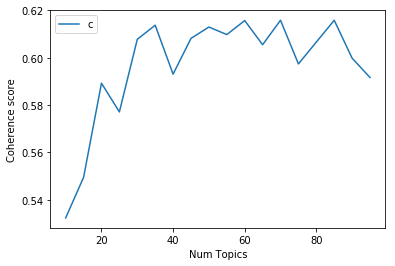

In [34]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.5323
Num Topics = 15  has Coherence Value of 0.5494
Num Topics = 20  has Coherence Value of 0.5892
Num Topics = 25  has Coherence Value of 0.5771
Num Topics = 30  has Coherence Value of 0.6078
Num Topics = 35  has Coherence Value of 0.6137
Num Topics = 40  has Coherence Value of 0.5931
Num Topics = 45  has Coherence Value of 0.6082
Num Topics = 50  has Coherence Value of 0.613
Num Topics = 55  has Coherence Value of 0.6098
Num Topics = 60  has Coherence Value of 0.6157
Num Topics = 65  has Coherence Value of 0.6055
Num Topics = 70  has Coherence Value of 0.6158
Num Topics = 75  has Coherence Value of 0.5974
Num Topics = 80  has Coherence Value of 0.6066
Num Topics = 85  has Coherence Value of 0.6158
Num Topics = 90  has Coherence Value of 0.5998
Num Topics = 95  has Coherence Value of 0.5916


### 4.2 What are the topics in each article?

One of the practical application of topic modeling is to determine what topic a given article is about. To find that, we find the topic number that has the highest percentage contribution in that article.

The `format_topics_sentences()` function below nicely aggregates this information in a presentable table.

In [36]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return(sent_topics_df)

In [37]:
df_topic_sents_keywords = format_topics_sentences(corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.3743,"land, office, provincial, canterbury, notice, ...",fTIHE price of Advertisements in this Paper ■A...
1,1,10.0,0.4355,"church, esq, meeting, society, committee, noti...","NOTICE. NOTICE IS HEREBY GIVEN, that on Tuesda..."
2,2,3.0,0.3735,"apply, good, street, beg, public, notice, info...",mENDERS will be received by the Fiee J- Commit...
3,3,12.0,0.4605,"case, sale, cask, box, hhds, ton, tea, ditto, ...","A CARD. RICHAED BEAMISH, GENERAL COMMISSION ME..."
4,4,12.0,0.7659,"case, sale, cask, box, hhds, ton, tea, ditto, ...","TO BE SOLD, ABOUT THIRTY ACRES of the best tim..."
5,5,12.0,0.9753,"case, sale, cask, box, hhds, ton, tea, ditto, ...","FOR SALE, ex RETURN. ICASE FRUIT TREES, just a..."
6,6,12.0,0.5300,"case, sale, cask, box, hhds, ton, tea, ditto, ...",TABLE OF DUTIES OF CUSTOMS.Passed the Legislat...
7,7,9.0,0.3653,"acre, land, apply, sale, section, street, hous...","sales b;y auction, MESSRS. LONGDEN and LE CHEN..."
8,8,9.0,0.8243,"acre, land, apply, sale, section, street, hous...","VALUABLE FREEHOLD ESTATE, Galled "" The Avon Va..."
9,9,12.0,0.3355,"case, sale, cask, box, hhds, ton, tea, ditto, ...","REMOVAL, J^ R E . DOBSON, Architect and Land J..."


### 4.2 How to find the most representative articles for each topic?

In another perspective we can find which articles most representative for each topic.

In [38]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9984,"ton, wellington, ship, passenger, freight, age...","DUNEDIN.Arrivals—Foreigh. Oct. 3, brig' Mounta..."
1,1.0,0.9900,"man, great, make, give, lord, year, day, peopl...",TWO YEARS OLD.Playing on the carpet near me Is...
2,2.0,0.9950,"wool, undersigned, london, produce, agent, com...",THE LIVERPOOL AND LONDON FIRE AND LIFE INSURAN...
3,3.0,0.9953,"apply, good, street, beg, public, notice, info...",STEAM TO PIGEON BAY. 'TIHE Steamer EXPERT will...
4,4.0,0.9891,"government, make, public, present, colony, pro...","The Lyttelton Times.Saturday, February 2, 1861..."
5,5.0,0.9619,"house, council, mr, bill, government, member, ...",GENERAL ASSEMBLY OF NEW ZEALAND.LEGISLATIVE CO...
6,6.0,0.9857,"day, make, work, time, water, foot, man, road,...",METEOROLOGICAL TABLE.Barometer. Fah. iherm. is...
7,7.0,0.9950,"street, general, agent, london, cashel, office...","MR. J. H. BURTON, DENTAL SURGEON, FBOM 96,, NE..."
8,8.0,0.9967,"sale, auction, sell, public, horse, market, cl...","EARTHENWARE, GLASS AND CHINA WAREHOUSE, IRONMO..."
9,9.0,0.9979,"acre, land, apply, sale, section, street, hous...","1«' Uit 8 A I, li . /?,TK ACRES FREEHOLD LAND ..."


### 4.3 What is the topic distribution across articles?

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [39]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,13.0,"land, office, provincial, canterbury, notice, ...",1919.0,0.0664
1,10.0,"church, esq, meeting, society, committee, noti...",1276.0,0.0441
2,3.0,"apply, good, street, beg, public, notice, info...",1297.0,0.0449
3,12.0,"case, sale, cask, box, hhds, ton, tea, ditto, ...",2456.0,0.0850
4,12.0,"case, sale, cask, box, hhds, ton, tea, ditto, ...",2642.0,0.0914
5,12.0,"case, sale, cask, box, hhds, ton, tea, ditto, ...",938.0,0.0325
6,12.0,"case, sale, cask, box, hhds, ton, tea, ditto, ...",1392.0,0.0482
7,9.0,"acre, land, apply, sale, section, street, hous...",906.0,0.0313
8,9.0,"acre, land, apply, sale, section, street, hous...",1459.0,0.0505
9,12.0,"case, sale, cask, box, hhds, ton, tea, ditto, ...",3128.0,0.1082


### 4.4 What topics match our expectations about the Lyttelton Times? (Interpretation)

At First we display the first 10 topics. Here we use the keys file from MALLET in Python, using 35 as tompic number parameter based on above coherence value metric.

In [113]:
df_keys = pd.read_table(keys_path, header=None).iloc[:10]
df_keys.shape

df_keys.columns = ['#', '##', 'keys']
with pd.option_context('display.max_colwidth', 120):
    print(df_keys[['keys']].head(10))

                                                                                                                      keys
0  white black lady boot man cloth silk shirt boy good dress fancy child shoe variety assortment colour cotton brown la...
1  street beg public inform good business order make inhabitant hotel patronage receive london house open canterbury ho...
2           road river line foot south mile work north water bridge side district west sea port bank hill east town chain 
3           case sale cask hhds ditto box qr_cask tea sherry port store soap chest ale wine brandy white sugar assort ton 
4  price market bank wool sale good wheat flour rate sell ton follow sydney week bushel stock report bale quantity busi...
5  sir make public letter question give association opinion land subject settlement state matter mr government time pre...
6         man great people good country make public england give year thing power fact world life work find long mind law 
7  land office p

From above topic keys displayed, we manually add topics beside the keys.

In [114]:
df_keys['topic'] = ['dress', 'NA', 'transportation', 'cargo', 'business', 'politics', 'NA', 'land', 'NA', 'business']
df_keys.set_index('#', inplace=True)
df_keys.head(10)

,##,keys,topic
#,,,
0,0.02881,white black lady boot man cloth silk shirt boy...,dress
1,0.04922,street beg public inform good business order m...,NA
2,0.02726,road river line foot south mile work north wat...,transportation
3,0.04857,case sale cask hhds ditto box qr_cask tea sher...,cargo
4,0.02263,price market bank wool sale good wheat flour r...,business
5,0.05278,sir make public letter question give associati...,politics
6,0.04294,man great people good country make public engl...,NA
7,0.03231,land office provincial canterbury notice secre...,land
8,0.08555,ihe ami arid li lie tin _ ai nt tho si fi ill ...,NA


We see the topics we added match our expectations, although the topics we added may not accurate or appropriate because they are subjective. The "NA" topic means we can not extract a topic from the keys.

#### 4.4.1 Identify "unusual" and "expected"

As we know that Lyttelton Times as a local paper of Lyttelton Harbour from 1851 to 1914, we expect the key words related to port, cargo, transportation and local life in that age.

The "unusual" key words are unrelated the main content of dataset, such as the 8 line key words, which is meanless strings and obviously the error words from OCR.

The "unusual" and "expected" keys are not absolute, they may differ from man to man, but some words are obviously abnormal or reasonable, then those words are our anchors to determine topics.

#### 4.4.2 What do topic groupings tell us about?

When the quality of topic modeling is distinct, we would see the general content of dataset or corpus.

In this case, from the first topic and keys, we see "dress" related words such as "boot", "cloth", "silk", "shirt" and "colour". While from the second topic keys we do not get logical relationship between the words and do not have a topic. And from the third topic keys we see "transportation" related words, especially "ship", such as "river", "line", "mile", "sea", "port", "bank", etc. We get other topics by the similar analysis to extract topics from the output of topic modeling.

So, to some extent we see some points related society, economy, or daily life from the key words, and extract to topics in our thought. But the key words which are the base of topics, are strongly depend on the quality of topic modeling, which is affected by many factors, such as dataset, algorithm, NLP process, implemental strategy and methods, etc., we would resolve those issues one by one in the later work of the project and obtain high quality topics eventually.

## 5 Conclusion

We started with installation of MALLET. We built a basic topic model using MALLET in command line. Then we built mallet’s LDA implementation using Gensim's LDA MALLET wrapper. After that we resolved how to find the optimal number of topics using coherence scores. Finally we try to aggregate and present the results to generate insights that may be in a more actionable between topics and articles.

The processing of topic modeling using MALLET in this notebook is work, however, there are still some works left to do in next step (such as correction of wrong words, using TF-IDF to filter noise, parallel computing, time sensitive model, etc.), there are many spaces to improve the solution.

# Reference

http://mallet.cs.umass.edu/download.php

http://mallet.cs.umass.edu/import.php

https://github.com/mimno/Mallet

https://programminghistorian.org/en/lessons/topic-modeling-and-mallet

https://rare-technologies.com/tutorial-on-mallet-in-python

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

https://radimrehurek.com/gensim/models/wrappers/ldamallet.html

https://radimrehurek.com/gensim/models/coherencemodel.html